In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from statsmodels.stats.anova import AnovaRM
COLOR_LEC = [0.0, 0.7412, 0.2941]
COLOR_MEC = [0.0, 0.0, 0.7608]
COLOR_MEC_LEC = [0.6196, 0.8, 0.2706]
COLOR_LEC_MEC = [0, 0.7451, 0.9529]
LS_LEC = '-'
LS_MEC = '-'
LS_MEC_LEC = '--'
LS_LEC_MEC = '--'
plt.rcParams['svg.fonttype'] = 'none'

Load, preprocess data

In [2]:
%%time
df = pd.read_pickle('/home/larend/data/dvorak-ca3/ds_aligned_spikes_df.pkl')
df = df.reorder_levels(['condition', 'isi', 'session', 'cell'])
RAW_DATA = df.sort_index()

CPU times: user 8.13 s, sys: 3min 38s, total: 3min 46s
Wall time: 4min 10s


In [3]:
RAW_DATA.sample(3)

sample                                   0     1     2     3     4     5     \
condition isi  session             cell                                       
0         2688 2020-03-11_16-43-44 323      0     0     0     0     0     0   
          649  2020-03-13_17-14-09 285      0     0     0     0     0     0   
2         2267 2020-03-13_18-19-05 102      0     0     0     0     0     0   

sample                                   6     7     8     9     ...  2490  \
condition isi  session             cell                          ...         
0         2688 2020-03-11_16-43-44 323      0     0     0     0  ...     0   
          649  2020-03-13_17-14-09 285      0     0     0     0  ...     0   
2         2267 2020-03-13_18-19-05 102      0     0     0     0  ...     0   

sample                                   2491  2492  2493  2494  2495  2496  \
condition isi  session             cell                                       
0         2688 2020-03-11_16-43-44 323      0     0     0     0     0     0   
          649  2020-03-13_17-14-09 285      0     0     0     0     0     0   
2         2267 2020-03-13_18-19-05 102      0     0     0     0     0     0   

sample                                   2497  2498  2499  
condition isi  session             cell                    
0         2688 2020-03-11_16-43-44 323      0     0     0  
          649  2020-03-13_17-14-09 285      0     0     0  
2         2267 2020-03-13_18-19-05 102      0     0     0  

[3 rows x 2500 columns]

In [4]:
%%time
df = RAW_DATA
df = df.T.rolling(window=25, step=5, center=True, min_periods=25).sum().T
df = df.dropna(axis=1).astype('int')
t_ms = ((df.columns - 1250) * 0.4).astype('int') # convert sample index to window center time in milliseconds
df.columns = pd.Series(t_ms, name='time')
SPIKE_TRAINS = df # number of spikes in 10 ms window, step size 2 ms

CPU times: user 37 s, sys: 5.19 s, total: 42.2 s
Wall time: 42.2 s


In [5]:
SPIKE_TRAINS.sample(1)

,,,time,-494,-492,-490,-488,-486,-484,-482,-480,-478,-476,...,476,478,480,482,484,486,488,490,492,494
condition,isi,session,cell,,,,,,,,,,,,,,,,,,,,,
2,231,2020-03-13_16-54-24,92,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df = SPIKE_TRAINS
df = df > 0 # spiked in 10 ms window centered on this time?
condition = df.index.get_level_values('condition')
is_lec = condition.isin([0, 2])
index = pd.Series(is_lec, name='lec')
df = df.set_index(index, append=True)
df = df.groupby(['lec', 'session', 'cell']).mean()
SPIKE_PROB = df

In [7]:
SPIKE_PROB.sample(1)

,,time,-494,-492,-490,-488,-486,-484,-482,-480,-478,-476,...,476,478,480,482,484,486,488,490,492,494
lec,session,cell,,,,,,,,,,,,,,,,,,,,,
False,2020-03-11_16-43-44,131,0.066749,0.065513,0.063041,0.077874,0.07293,0.066749,0.060569,0.065513,0.060569,0.059333,...,0.074166,0.067985,0.060569,0.065513,0.063041,0.063041,0.067985,0.065513,0.065513,0.064277


In [19]:
df = SPIKE_PROB
SIZE = len(df.loc[True])
MEAN = df.groupby('lec').mean()
STD = df.groupby('lec').std()
SEM = STD / np.sqrt(SIZE)

Identify time point of peak response

In [20]:
mec_response = MEAN.loc[False]
PEAK_TIME = mec_response.idxmax()
print('MEC response peak time', PEAK_TIME)

MEC response peak time -4


Quantify response around peak time

In [21]:
WINDOW_RADIUS = 20 # ms
df = SPIKE_PROB
df = pd.DataFrame(scipy.stats.zscore(df, axis=1), df.index, df.columns) # z-score PSTH for each cell
df = df.loc[:, PEAK_TIME - WINDOW_RADIUS:PEAK_TIME + WINDOW_RADIUS] # take window around peak time
SCORE_max = df.max(axis=1) # max probability found in window
SCORE_diff = df.max(axis=1) - df.min(axis=1) # max - min probability found in window

Test for difference between response to MEC and LEC

In [22]:
print('LEC vs MEC (max)', scipy.stats.wilcoxon(SCORE_max.loc[True], SCORE_max.loc[False]))
print('LEC vs MEC (diff)', scipy.stats.wilcoxon(SCORE_diff.loc[True], SCORE_diff.loc[False]))

LEC vs MEC (max) WilcoxonResult(statistic=np.float64(4924.0), pvalue=np.float64(1.5313796133822e-22))
LEC vs MEC (diff) WilcoxonResult(statistic=np.float64(6482.0), pvalue=np.float64(2.6119347768117992e-17))


Plot PSTH (main text Fig. 6b)

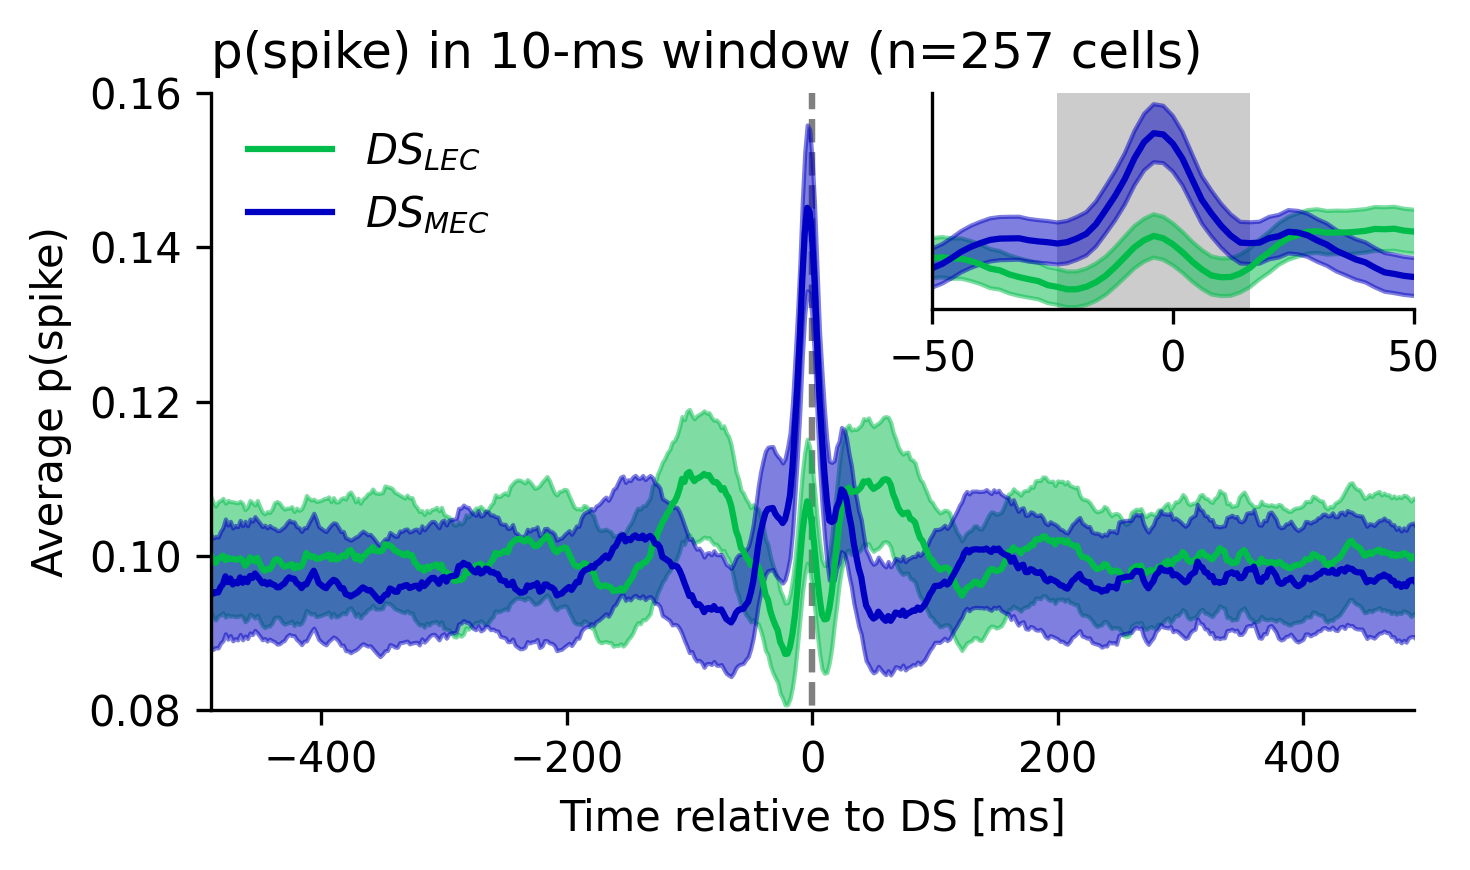

In [23]:
x = MEAN.columns
y_lec = MEAN.loc[True]
y_mec = MEAN.loc[False]
yerr_lec = SEM.loc[True]
yerr_mec = SEM.loc[False]

plt.figure(dpi=300, tight_layout=True, figsize=(5, 3))
plt.title(f'p(spike) in 10-ms window (n={SIZE} cells)', loc='left')
plt.xlabel('Time relative to DS [ms]')
plt.ylabel(f'Average p(spike)')

plt.plot(x, y_lec, color=COLOR_LEC, label='$DS_{LEC}$')
plt.fill_between(x, y_lec - yerr_lec, y_lec + yerr_lec, alpha=0.5, color=COLOR_LEC)
plt.plot(x, y_mec, color=COLOR_MEC, label='$DS_{MEC}$')
plt.fill_between(x, y_mec - yerr_mec, y_mec + yerr_mec, alpha=0.5, color=COLOR_MEC)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.ylim(0.08, 0.16)
plt.xlim(-490, 490)
plt.vlines(0, 0, 1, color='gray', ls='--', zorder=-10)
plt.legend(loc='upper left', frameon=False)

ax = plt.gca().inset_axes([0.6, 0.65, 0.4, 0.35])
ax.plot(x, y_lec, color=COLOR_LEC)
ax.fill_between(x, y_lec - yerr_lec, y_lec + yerr_lec, alpha=0.5, color=COLOR_LEC)
ax.plot(x, y_mec, color=COLOR_MEC)
ax.fill_between(x, y_mec - yerr_mec, y_mec + yerr_mec, alpha=0.5, color=COLOR_MEC)
ax.fill_betweenx([0, 1], 2 * [PEAK_TIME - WINDOW_RADIUS], 2 * [PEAK_TIME + WINDOW_RADIUS], color='black', zorder=-10, alpha=0.2, edgecolor='none')
ax.set_ylim(0.08, 0.16)
ax.set_xlim(-50, 50)
plt.vlines(0, 0, 1, color='gray', ls='--', zorder=-10)
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('figures/figure_6b.svg')
plt.show()

Plot quantification of response (both methods of quantification; main text Fig. 6c)

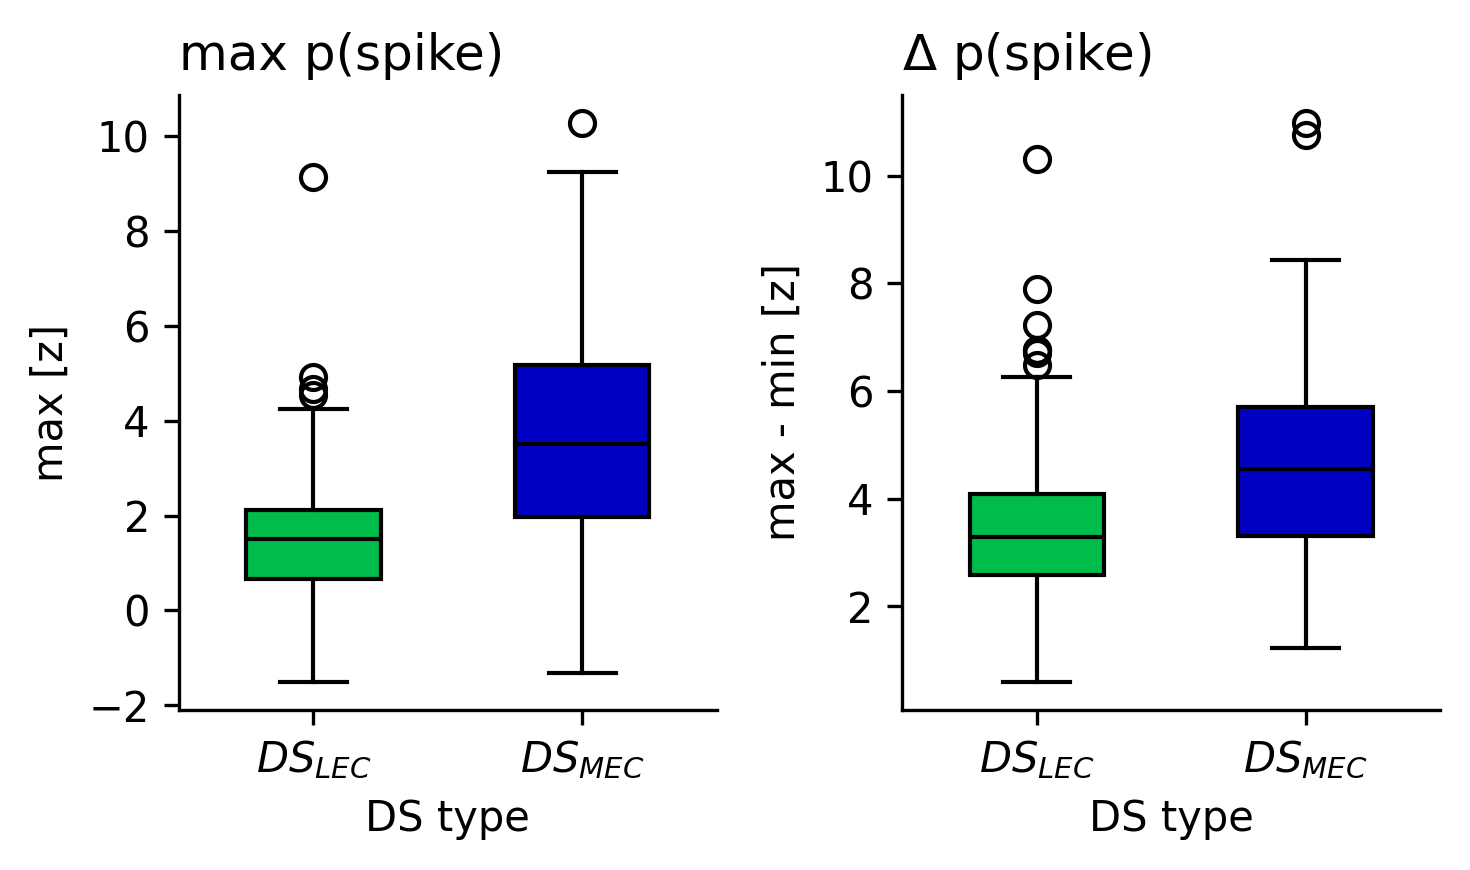

In [24]:
x1 = [SCORE_max.loc[True], SCORE_max.loc[False]]
x2 = [SCORE_diff.loc[True], SCORE_diff.loc[False]]
positions = [0, 1]
labels = ['$DS_{LEC}$', '$DS_{MEC}$']

plt.figure(dpi=300, tight_layout=True, figsize=(5, 3))

plt.subplot(1, 2, 1)
plt.title(f'max p(spike)', loc='left')
plot = plt.boxplot(x1, positions=positions, patch_artist=True, medianprops=dict(color='black'), widths=0.5)
for i, patch in enumerate(plot['boxes']):
    color = [COLOR_LEC, COLOR_MEC][i]
    patch.set_facecolor(color)
plt.xticks(positions, labels)
plt.ylabel('max [z]')
plt.xlabel('DS type')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.subplot(1, 2, 2)
plt.title(f'$\\Delta$ p(spike)', loc='left')
plot = plt.boxplot(x2, positions=positions, patch_artist=True, medianprops=dict(color='black'), widths=0.5)
for i, patch in enumerate(plot['boxes']):
    color = [COLOR_LEC, COLOR_MEC][i]
    patch.set_facecolor(color)
plt.xticks(positions, labels)
plt.ylabel('max - min [z]')
plt.xlabel('DS type')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.savefig('figures/figure_6c.svg')
plt.show()

Analyze combinations (restrict to pairs within two theta cycles)

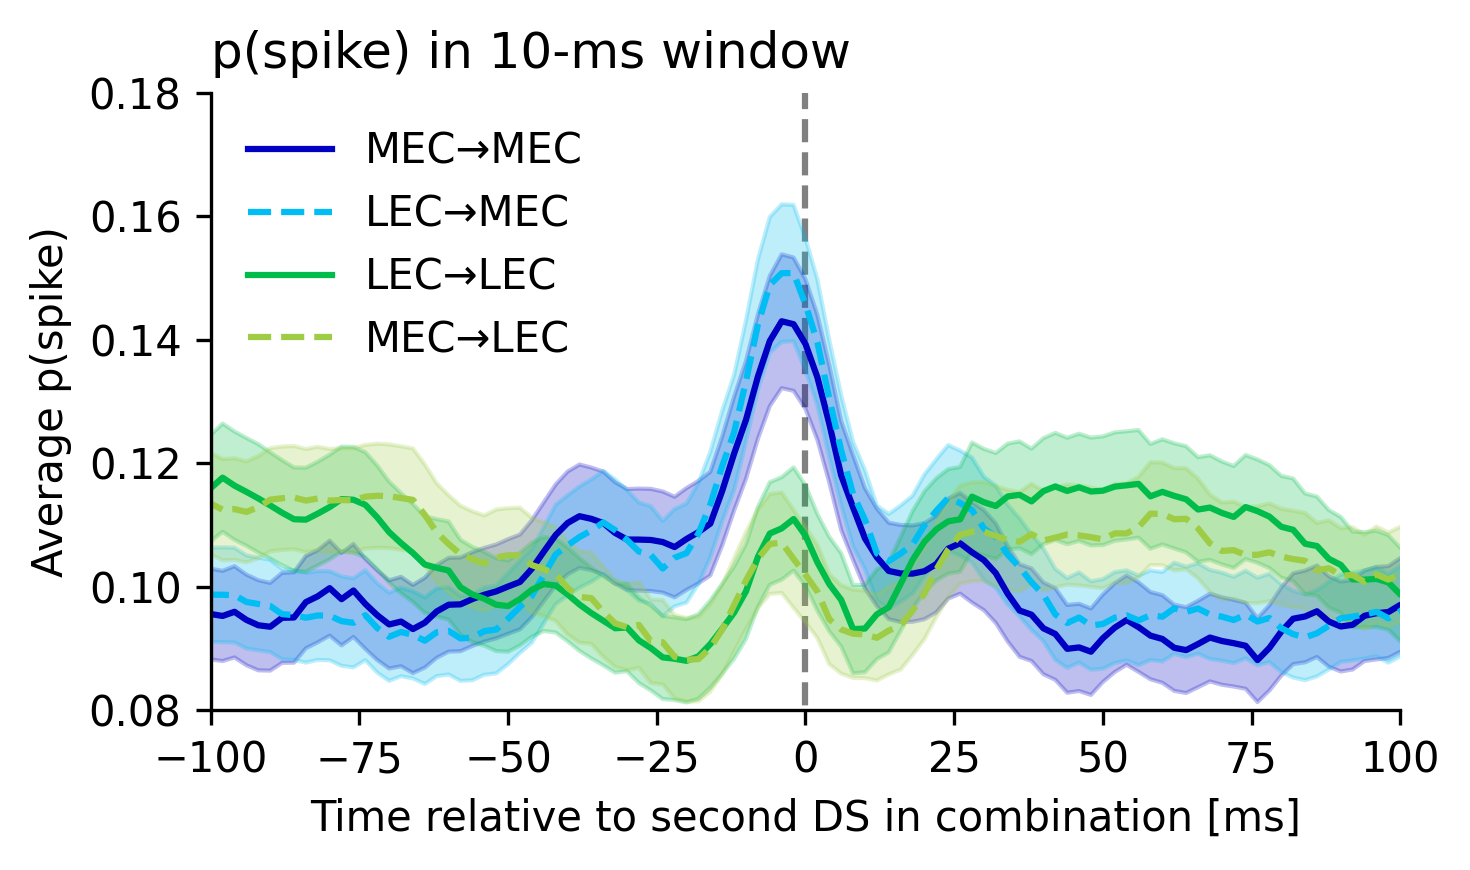

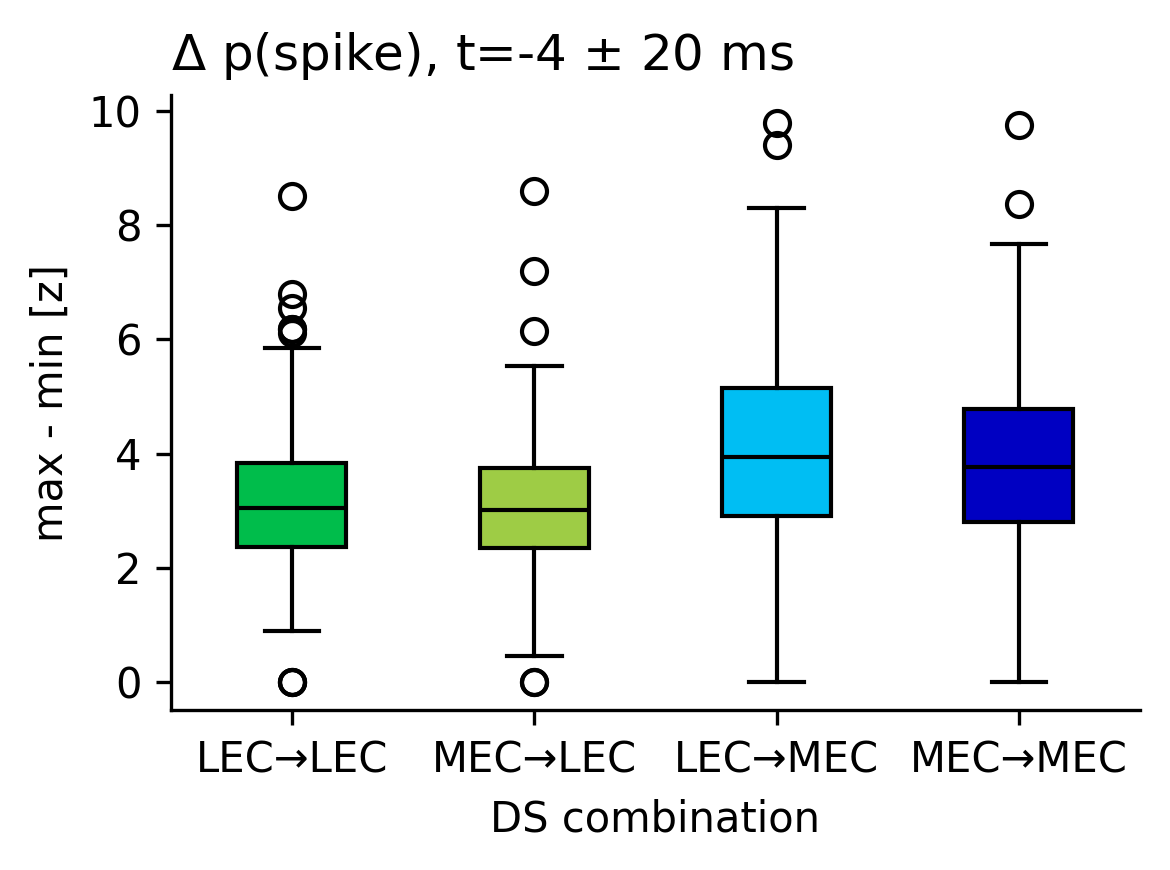

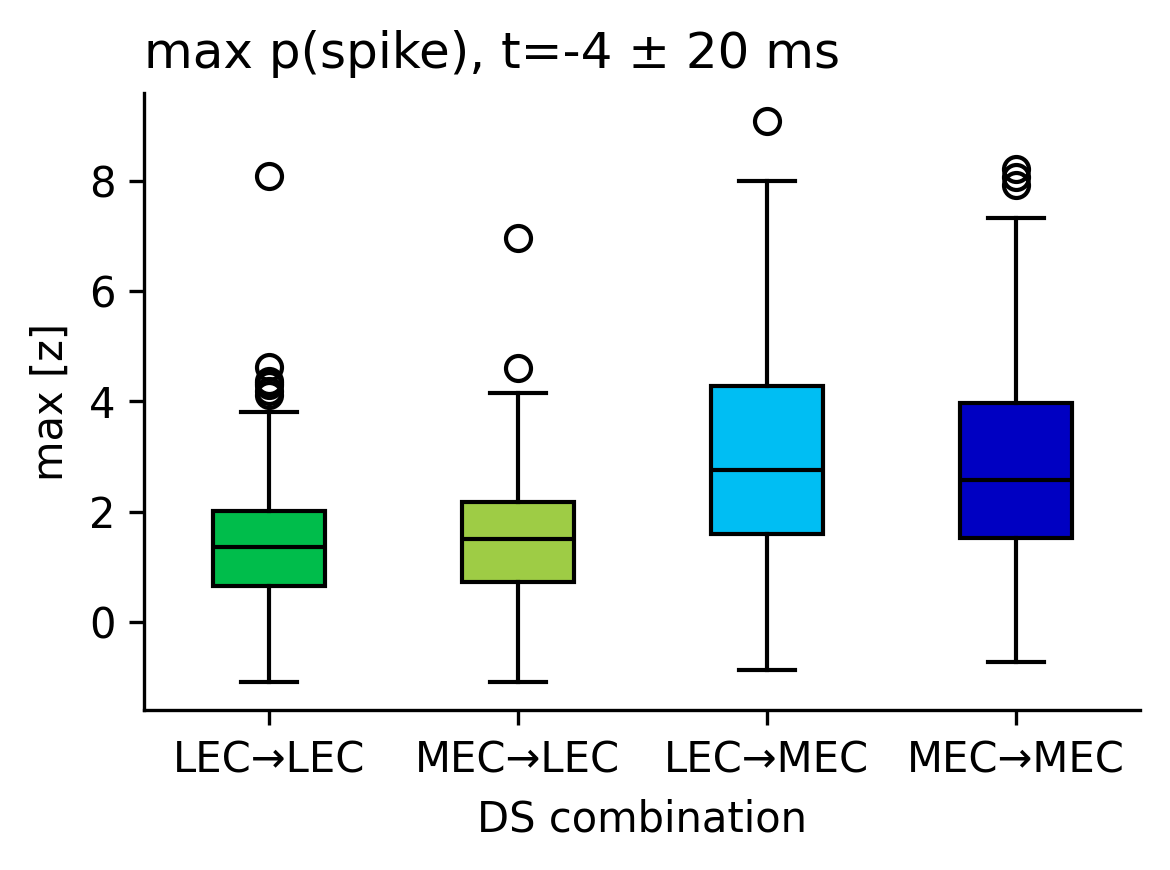

In [26]:
df = SPIKE_TRAINS
THETA_CYCLE_ISI = 2500/7 # sample count in a 7-Hz cycle
df = df.loc[pd.IndexSlice[:, :2*THETA_CYCLE_ISI, :], :] # restrict to combinations less than 2 theta cycles apart
df = df > 0 # spiked in 10 ms window centered on this time?
df = df.groupby(['condition', 'session', 'cell']).mean()
SPIKE_PROB2 = df

df = SPIKE_PROB2
SIZE = len(df.loc[0])
MEAN = df.groupby('condition').mean()
STD = df.groupby('condition').std()
SEM = STD / np.sqrt(SIZE)

df = pd.DataFrame(scipy.stats.zscore(df, axis=1), df.index, df.columns)
df = df.loc[:, PEAK_TIME - WINDOW_RADIUS:PEAK_TIME + WINDOW_RADIUS] # take window around peak time
SCORE_max = df.max(axis=1)
SCORE_diff = df.max(axis=1) - df.min(axis=1)

x = MEAN.columns
y_lec_lec = MEAN.loc[0]
y_lec_mec = MEAN.loc[1]
y_mec_lec = MEAN.loc[2]
y_mec_mec = MEAN.loc[3]
yerr_lec_lec = SEM.loc[0]
yerr_lec_mec = SEM.loc[1]
yerr_mec_lec = SEM.loc[2]
yerr_mec_mec = SEM.loc[3]
labels = ['LEC→LEC', 'LEC→MEC', 'MEC→LEC', 'MEC→MEC']

plt.figure(dpi=300, tight_layout=True, figsize=(5, 3))
plt.title(f'p(spike) in 10-ms window', loc='left')
plt.xlabel('Time relative to second DS in combination [ms]')
plt.ylabel(f'Average p(spike)')

plt.plot(x, y_mec_mec, color=COLOR_MEC, label='MEC→MEC', ls=LS_MEC)
plt.fill_between(x, y_mec_mec - yerr_mec_mec, y_mec_mec + yerr_mec_mec, alpha=0.25, color=COLOR_MEC)
plt.plot(x, y_lec_mec, color=COLOR_LEC_MEC, label='LEC→MEC', ls=LS_LEC_MEC)
plt.fill_between(x, y_lec_mec - yerr_lec_mec, y_lec_mec + yerr_lec_mec, alpha=0.25, color=COLOR_LEC_MEC)
plt.plot(x, y_lec_lec, color=COLOR_LEC, label='LEC→LEC', ls=LS_LEC)
plt.fill_between(x, y_lec_lec - yerr_lec_lec, y_lec_lec + yerr_lec_lec, alpha=0.25, color=COLOR_LEC)
plt.plot(x, y_mec_lec, color=COLOR_MEC_LEC, label='MEC→LEC', ls=LS_MEC_LEC)
plt.fill_between(x, y_mec_lec - yerr_mec_lec, y_mec_lec + yerr_mec_lec, alpha=0.25, color=COLOR_MEC_LEC)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.ylim(0.08, 0.18)
plt.xlim(-100, 100)
plt.vlines(0, 0, 1, color='gray', ls='--', zorder=-10)
plt.legend(loc='upper left', frameon=False)

plt.savefig('figures/figure_6e.svg')
plt.show()

x = SCORE_diff.unstack(level=0)[[0, 2, 1, 3]]
positions = [0, 1, 2, 3]
labels = ['LEC→LEC', 'MEC→LEC', 'LEC→MEC', 'MEC→MEC']

plt.figure(dpi=300, tight_layout=True, figsize=(4, 3))
plt.title(f'$\\Delta$ p(spike), t={PEAK_TIME} ± {WINDOW_RADIUS} ms', loc='left')
plot = plt.boxplot(x, positions=positions, patch_artist=True, medianprops=dict(color='black'))
for i, patch in enumerate(plot['boxes']):
    color = [COLOR_LEC, COLOR_MEC_LEC, COLOR_LEC_MEC, COLOR_MEC][i]
    patch.set_facecolor(color)
plt.xticks(positions, labels)
plt.ylabel('max - min [z]')
plt.xlabel('DS combination')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.savefig('figures/figure_6f.svg')
plt.show()

x = SCORE_max.unstack(level=0)[[0, 2, 1, 3]]

plt.figure(dpi=300, tight_layout=True, figsize=(4, 3))
plt.title(f'max p(spike), t={PEAK_TIME} ± {WINDOW_RADIUS} ms', loc='left')
plot = plt.boxplot(x, positions=positions, patch_artist=True, medianprops=dict(color='black'))
for i, patch in enumerate(plot['boxes']):
    color = [COLOR_LEC, COLOR_MEC_LEC, COLOR_LEC_MEC, COLOR_MEC][i]
    patch.set_facecolor(color)
plt.xticks(positions, labels)
plt.ylabel('max [z]')
plt.xlabel('DS combination')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.savefig('figures/figure_S6e.svg')
plt.show()

Test for difference in response based on combinations

In [28]:
session = SCORE_diff.index.get_level_values('session')
cell = SCORE_diff.index.get_level_values('cell')
condition = SCORE_diff.index.get_level_values('condition')
event1 = ['LEC' if c else 'MEC' for c in condition.isin([0, 1])]
event2 = ['LEC' if c else 'MEC' for c in condition.isin([0, 2])]
df = pd.DataFrame({
    'cell': [f'{s}:{c}' for s, c in zip(session, cell)],
    'condition': condition,
    'score': SCORE_diff.values,
    'event1': event1,
    'event2': event2,
})
aovrm = AnovaRM(data=df,
                depvar='score',
                subject='cell',
                within=['event1', 'event2'])
res = aovrm.fit()
print("Max - min scoring")
print(res)

session = SCORE_max.index.get_level_values('session')
cell = SCORE_max.index.get_level_values('cell')
condition = SCORE_max.index.get_level_values('condition')
event1 = ['LEC' if c else 'MEC' for c in condition.isin([0, 1])]
event2 = ['LEC' if c else 'MEC' for c in condition.isin([0, 2])]
df = pd.DataFrame({
    'cell': [f'{s}:{c}' for s, c in zip(session, cell)],
    'condition': condition,
    'score': SCORE_max.values,
    'event1': event1,
    'event2': event2,
})
aovrm = AnovaRM(data=df,
                depvar='score',
                subject='cell',
                within=['event1', 'event2'])
res = aovrm.fit()
print("Max scoring")
print(res)

Max - min scoring
                   Anova
              F Value Num DF  Den DF  Pr > F
--------------------------------------------
event1         5.0709 1.0000 256.0000 0.0252
event2        86.8555 1.0000 256.0000 0.0000
event1:event2  0.5594 1.0000 256.0000 0.4552

Max scoring
                    Anova
              F Value  Num DF  Den DF  Pr > F
---------------------------------------------
event1          2.3276 1.0000 256.0000 0.1283
event2        124.6106 1.0000 256.0000 0.0000
event1:event2   3.2547 1.0000 256.0000 0.0724



<50-ms combination analysis (Fig. S6a-b)

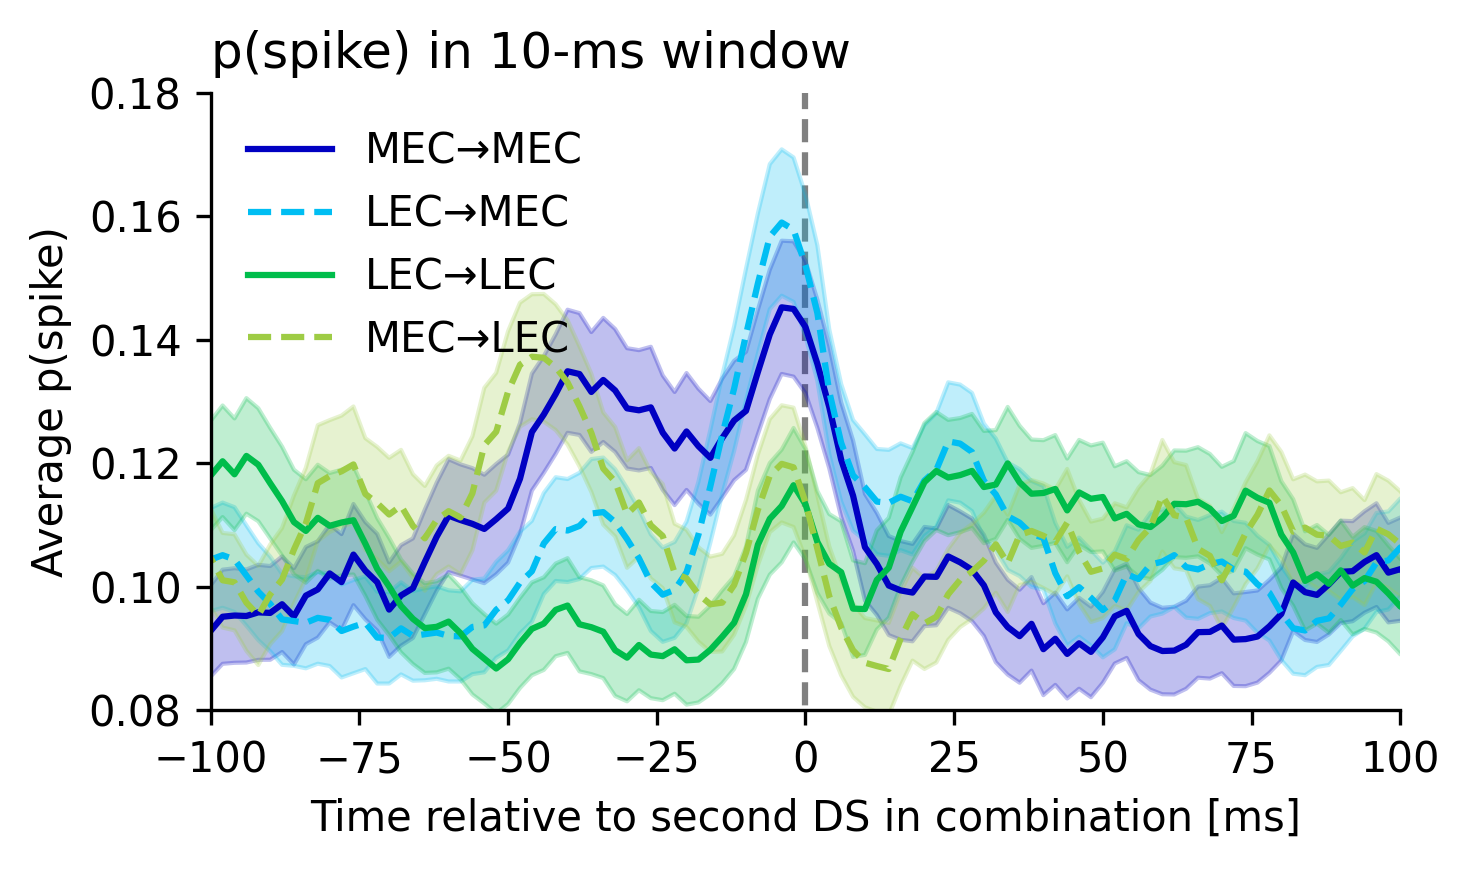

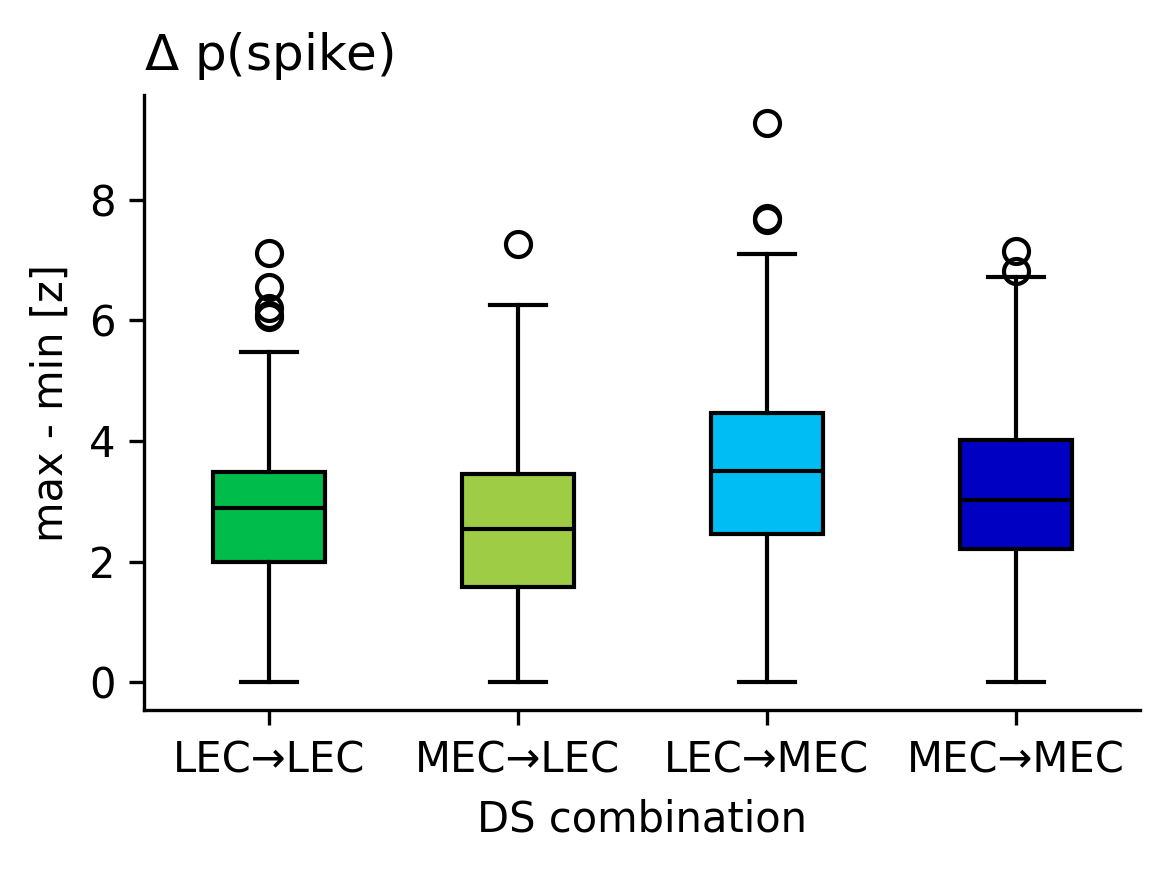

In [29]:
df = SPIKE_TRAINS
ISI_50ms = 50 / 0.4
df = df.loc[pd.IndexSlice[:, :ISI_50ms, :], :] # restrict to combinations less than 50 ms apart
df = df > 0 # spiked in 10 ms window centered on this time?
df = df.groupby(['condition', 'session', 'cell']).mean()
SPIKE_PROB2 = df

df = SPIKE_PROB2
SIZE = len(df.loc[0])
MEAN = df.groupby('condition').mean()
STD = df.groupby('condition').std()
SEM = STD / np.sqrt(SIZE)

df = pd.DataFrame(scipy.stats.zscore(df, axis=1), df.index, df.columns)
df = df.loc[:, PEAK_TIME - WINDOW_RADIUS:PEAK_TIME + WINDOW_RADIUS] # take window around peak time
SCORE_max = df.max(axis=1)
SCORE_diff = df.max(axis=1) - df.min(axis=1)

x = MEAN.columns
y_lec_lec = MEAN.loc[0]
y_lec_mec = MEAN.loc[1]
y_mec_lec = MEAN.loc[2]
y_mec_mec = MEAN.loc[3]
yerr_lec_lec = SEM.loc[0]
yerr_lec_mec = SEM.loc[1]
yerr_mec_lec = SEM.loc[2]
yerr_mec_mec = SEM.loc[3]
labels = ['LEC→LEC', 'LEC→MEC', 'MEC→LEC', 'MEC→MEC']

plt.figure(dpi=300, tight_layout=True, figsize=(5, 3))
plt.title(f'p(spike) in 10-ms window', loc='left')
plt.xlabel('Time relative to second DS in combination [ms]')
plt.ylabel(f'Average p(spike)')

plt.plot(x, y_mec_mec, color=COLOR_MEC, label='MEC→MEC', ls=LS_MEC)
plt.fill_between(x, y_mec_mec - yerr_mec_mec, y_mec_mec + yerr_mec_mec, alpha=0.25, color=COLOR_MEC)
plt.plot(x, y_lec_mec, color=COLOR_LEC_MEC, label='LEC→MEC', ls=LS_LEC_MEC)
plt.fill_between(x, y_lec_mec - yerr_lec_mec, y_lec_mec + yerr_lec_mec, alpha=0.25, color=COLOR_LEC_MEC)
plt.plot(x, y_lec_lec, color=COLOR_LEC, label='LEC→LEC', ls=LS_LEC)
plt.fill_between(x, y_lec_lec - yerr_lec_lec, y_lec_lec + yerr_lec_lec, alpha=0.25, color=COLOR_LEC)
plt.plot(x, y_mec_lec, color=COLOR_MEC_LEC, label='MEC→LEC', ls=LS_MEC_LEC)
plt.fill_between(x, y_mec_lec - yerr_mec_lec, y_mec_lec + yerr_mec_lec, alpha=0.25, color=COLOR_MEC_LEC)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.ylim(0.08, 0.18)
plt.xlim(-100, 100)
plt.vlines(0, 0, 1, color='gray', ls='--', zorder=-10)
plt.legend(loc='upper left', frameon=False)

plt.savefig('figures/figure_S6a.svg')
plt.show()

x = SCORE_diff.unstack(level=0)[[0, 2, 1, 3]]
positions = [0, 1, 2, 3]
labels = ['LEC→LEC', 'MEC→LEC', 'LEC→MEC', 'MEC→MEC']

plt.figure(dpi=300, tight_layout=True, figsize=(4, 3))
plt.title(f'$\\Delta$ p(spike)', loc='left')
plot = plt.boxplot(x, positions=positions, patch_artist=True, medianprops=dict(color='black'))
for i, patch in enumerate(plot['boxes']):
    color = [COLOR_LEC, COLOR_MEC_LEC, COLOR_LEC_MEC, COLOR_MEC][i]
    patch.set_facecolor(color)
plt.xticks(positions, labels)
plt.ylabel('max - min [z]')
plt.xlabel('DS combination')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.savefig('figures/figure_S6b.svg')
plt.show()

In [30]:
session = SCORE_diff.index.get_level_values('session')
cell = SCORE_diff.index.get_level_values('cell')
condition = SCORE_diff.index.get_level_values('condition')
event1 = ['LEC' if c else 'MEC' for c in condition.isin([0, 1])]
event2 = ['LEC' if c else 'MEC' for c in condition.isin([0, 2])]
df = pd.DataFrame({
    'cell': [f'{s}:{c}' for s, c in zip(session, cell)],
    'condition': condition,
    'score': SCORE_diff.values,
    'event1': event1,
    'event2': event2,
})
aovrm = AnovaRM(data=df,
                depvar='score',
                subject='cell',
                within=['event1', 'event2'])
res = aovrm.fit()
print("Max - min scoring")
print(res)

session = SCORE_max.index.get_level_values('session')
cell = SCORE_max.index.get_level_values('cell')
condition = SCORE_max.index.get_level_values('condition')
event1 = ['LEC' if c else 'MEC' for c in condition.isin([0, 1])]
event2 = ['LEC' if c else 'MEC' for c in condition.isin([0, 2])]
df = pd.DataFrame({
    'cell': [f'{s}:{c}' for s, c in zip(session, cell)],
    'condition': condition,
    'score': SCORE_max.values,
    'event1': event1,
    'event2': event2,
})
aovrm = AnovaRM(data=df,
                depvar='score',
                subject='cell',
                within=['event1', 'event2'])
res = aovrm.fit()
print("Max scoring")
print(res)

Max - min scoring
                   Anova
              F Value Num DF  Den DF  Pr > F
--------------------------------------------
event1        22.7282 1.0000 256.0000 0.0000
event2        61.2048 1.0000 256.0000 0.0000
event1:event2  0.0007 1.0000 256.0000 0.9796

Max scoring
                   Anova
              F Value Num DF  Den DF  Pr > F
--------------------------------------------
event1         3.4914 1.0000 256.0000 0.0628
event2        91.5761 1.0000 256.0000 0.0000
event1:event2  2.5493 1.0000 256.0000 0.1116



In [31]:
cells = RAW_DATA.index.droplevel(['condition', 'isi']).unique()
sessions = cells.droplevel('cell').unique()
cell_df = cells.to_frame()
session_cell = {session: cell_df.loc[session].index[0] for session in sessions}
df = RAW_DATA.index.to_frame()
df = df.swaplevel(0, 2).swaplevel(1, 3).sort_index()
df = pd.concat([df.loc[session, session_cell[session]] for session in sessions])
df = df.drop(columns='cell')
df = df.set_index(np.arange(len(df)))
df['lec'] = df['condition'].isin([0, 2])
DENTATE_SPIKES = df

In [32]:
EVENT_COUNT = DENTATE_SPIKES['condition'].value_counts()

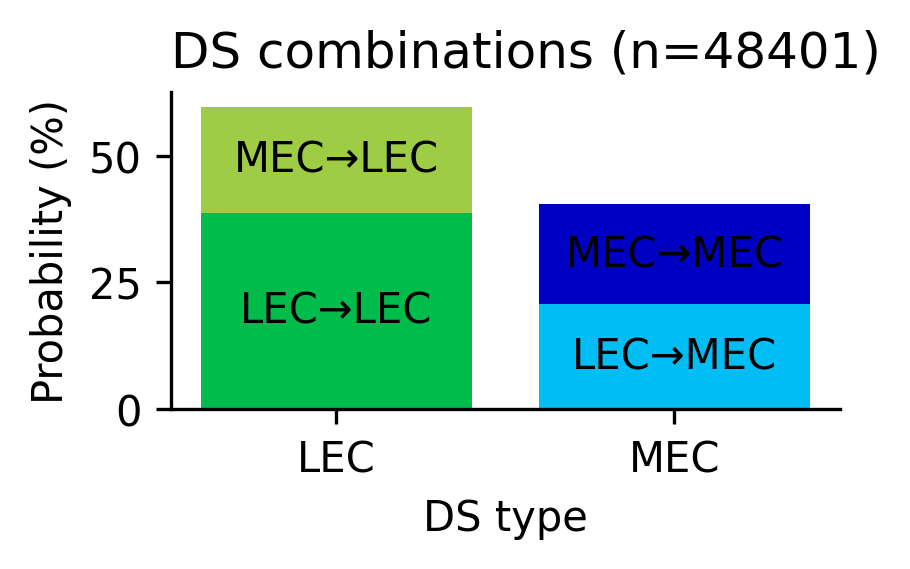

In [38]:
prob_lec_lec, prob_lec_mec, prob_mec_lec, prob_mec_mec = EVENT_COUNT / EVENT_COUNT.sum() * 100
n_event = EVENT_COUNT.sum()

plt.figure(figsize=(3, 2), tight_layout=True, dpi=300)
plt.title(f'DS combinations (n={n_event})', loc='left')
plt.bar([0], height=[prob_lec_lec], bottom=[0], color=COLOR_LEC, label='LEC→LEC')
plt.bar([0], height=[prob_mec_lec], bottom=[prob_lec_lec], color=COLOR_MEC_LEC, label='MEC→LEC')
plt.bar([1], height=[prob_lec_mec], bottom=[0], color=COLOR_LEC_MEC, label='LEC→MEC')
plt.bar([1], height=[prob_mec_mec], bottom=[prob_lec_mec], color=COLOR_MEC, label='MEC→MEC')
plt.text(x=0, y=prob_lec_lec / 2, s='LEC→LEC', ha='center', va='center')
plt.text(x=0, y=prob_lec_lec + prob_mec_lec / 2, s='MEC→LEC', ha='center', va='center')
plt.text(x=1, y=prob_lec_mec / 2, s='LEC→MEC', ha='center', va='center')
plt.text(x=1, y=prob_lec_mec + prob_mec_mec / 2, s='MEC→MEC', ha='center', va='center')
plt.xticks([0, 1], ['LEC', 'MEC'])
plt.ylabel('Probability (%)', loc='center')
plt.xlabel('DS type', loc='center')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('figures/figure_S6d.svg')
plt.show()

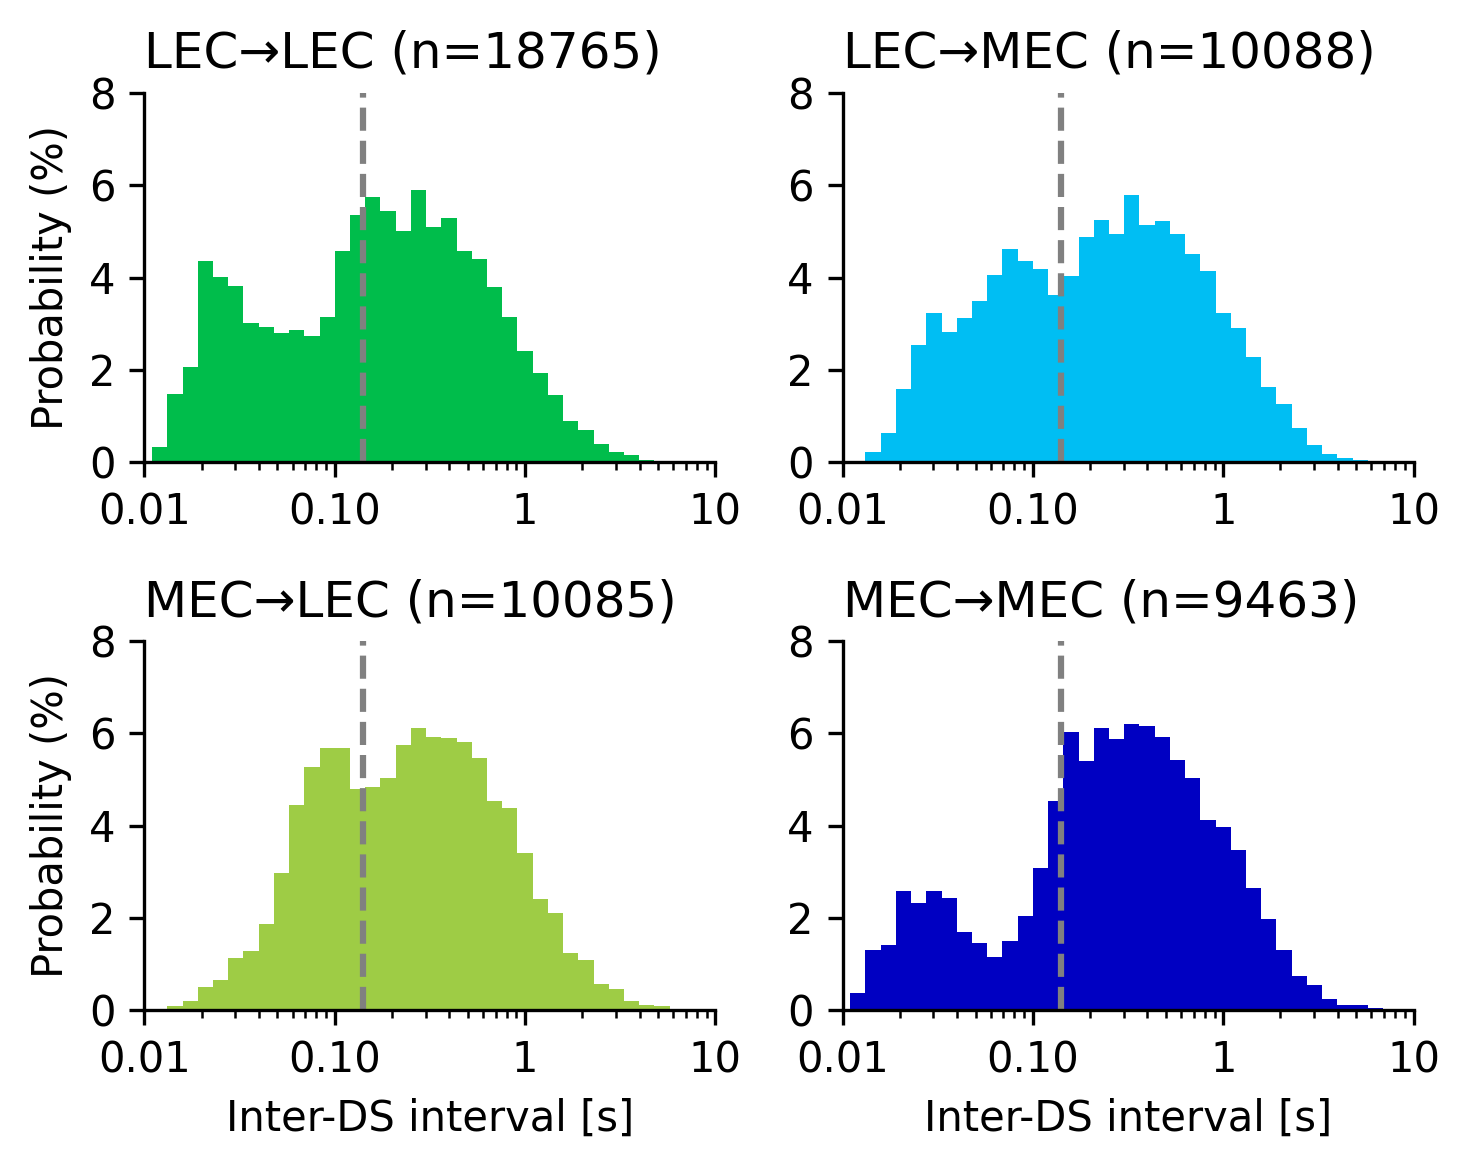

In [39]:
df = DENTATE_SPIKES
isi = df.set_index('condition')['isi'] * 0.4 # convert to ms
bins = np.logspace(np.log10(1), np.log10(10000), 51)
f = lambda x: pd.Series(np.histogram(x, bins=bins)[0])
df = isi.groupby('condition').apply(f).unstack()
labels = ['LEC→LEC', 'LEC→MEC', 'MEC→LEC', 'MEC→MEC']
colors = [COLOR_LEC, COLOR_LEC_MEC, COLOR_MEC_LEC, COLOR_MEC]

x = (bins[:-1] + bins[1:]) / 2
w = np.diff(bins)

plt.figure(dpi=300, tight_layout=True, figsize=(5, 4))

for i, condition in enumerate([0, 1, 2, 3]):
    subplot = i + 1
    count = df.loc[i]
    n = EVENT_COUNT.loc[i]
    y = count / count.sum() * 100
    c = colors[condition]
    title = f'{labels[condition]} (n={n})'
    
    plt.subplot(2, 2, subplot)
    plt.title(title, loc='left')
    plt.bar(x, y, width=w, color=c)
    plt.xscale('log')
    plt.xlim(10, 10000)
    plt.ylim(0, 8)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xticks([1e1, 1e2, 1e3, 1e4], ['0.01', '0.10', '1', '10'])
    plt.vlines(140, 0, 100, color='gray', ls='--')
    if i in [2, 3]:
        plt.xlabel('Inter-DS interval [s]')
    if i in [0, 2]:
        plt.ylabel('Probability (%)')

plt.savefig('figures/figure_S6c.svg')
plt.show()

In [36]:
count = SCORE_diff.loc[0].groupby('session').count()
print(count.sum())
print(count.mean(), count.std())
print(count.min(), count.max())

257
11.681818181818182 8.643116521455857
2 41


In [37]:
for date in ['2020-01-16', '2020-03-11', '2020-03-13']:
    print(count[count.index.str.startswith(date)].sum())

16
53
188
